# Potential Customer Revenue Calculation with Rule Based Classification

## Problem
A game company wants to create new level based customer definitions using some attributes of the customers and they want to 
create segments by using the new definitions to finally estimate how much profit can a newcustomer bring to the company when
compared to these segments. 

Example: How much profit can the company earn on a 25 year old male iOS user from Turkey?

## Dataset Summary
Persona.csv dataset contains the product prices of an international game company and demographic information of the customers.
The dataset is comprised of each transaction record which implies that the dataset is not singularized. In another words, 
a customer with certain demographic information could have more than 1 transaction.

**Price**: Customer's Payment \
**Source:** Customer's Device Type \
**Sex:** Customer's Sex \
**Country:** Customer's Country \
**Age:** Customer's Age

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../input/persona/persona.csv")

In [3]:
# A function is written to examine the general shape of the dataset
def general_info (dataframe, row_count = 5):
    print("--- Shape--- ")
    print(dataframe.shape)
    print("--- Data Types ---")
    print(dataframe.dtypes)
    print("--- Head ---")
    print(dataframe.head(row_count))
    print("--- Tail ---")
    print(dataframe.tail(row_count))
    print("--- Unique Values ---")
    for col in df.columns:
        print(col, df[col].nunique())
    print(dataframe.tail(row_count))
    print("--- Null Value ---")
    print(dataframe.isnull().sum())
    print("--- Quantiles ---")
    print(dataframe.describe().T)

general_info(df)

--- Shape--- 
(5000, 5)
--- Data Types ---
PRICE       int64
SOURCE     object
SEX        object
COUNTRY    object
AGE         int64
dtype: object
--- Head ---
   PRICE   SOURCE   SEX COUNTRY  AGE
0     39  android  male     bra   17
1     39  android  male     bra   17
2     49  android  male     bra   17
3     29  android  male     tur   17
4     49  android  male     tur   17
--- Tail ---
      PRICE   SOURCE     SEX COUNTRY  AGE
4995     29  android  female     bra   31
4996     29  android  female     bra   31
4997     29  android  female     bra   31
4998     39  android  female     bra   31
4999     29  android  female     bra   31
--- Unique Values ---
PRICE 6
SOURCE 2
SEX 2
COUNTRY 6
AGE 46
      PRICE   SOURCE     SEX COUNTRY  AGE
4995     29  android  female     bra   31
4996     29  android  female     bra   31
4997     29  android  female     bra   31
4998     39  android  female     bra   31
4999     29  android  female     bra   31
--- Null Value ---
PRICE      0
SOURCE 

In [4]:
"""
The dataset variables are examined to ensure their data types. Some numerical variables can be treated as categorical if they have low unique value counts and similarly some categorical variables can
have high unique value counts so they are treated as cardinal variables. For this application variable_catcher function is written.
"""
def variable_catcher(dataframe, cat_threshold = 5, car_threshold = 20):
    
    # To catch categorical variables
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtype) in ["object","category","bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_threshold and 
                   str(dataframe[col].dtype) in ["int64","float64"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_threshold and 
                   str(dataframe[col].dtype) in ["object","category"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # To catch numerical variables
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = variable_catcher(df)

Observations: 5000
Variables: 5
cat_cols: 3
num_cols: 2
cat_but_car: 0
num_but_cat: 0


In [5]:
# cat_summary function summarizes categorical variables by their frequency and percentages.
def cat_summary(dataframe, col_name):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

for col in cat_cols:
    cat_summary(df, col)

         SOURCE  Ratio
android    2974  59.48
ios        2026  40.52
##########################################
         SEX  Ratio
female  2621  52.42
male    2379  47.58
##########################################
     COUNTRY  Ratio
usa     2065  41.30
bra     1496  29.92
deu      455   9.10
tur      451   9.02
fra      303   6.06
can      230   4.60
##########################################


count    5000.000000
mean       34.132000
std        12.464897
min         9.000000
25%        29.000000
50%        39.000000
75%        39.000000
100%       59.000000
max        59.000000
Name: PRICE, dtype: float64


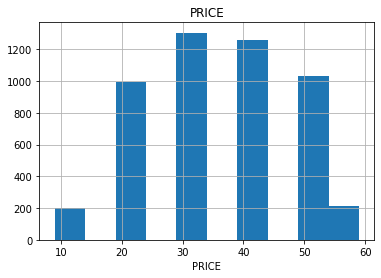

count    5000.000000
mean       23.581400
std         8.995908
min        15.000000
25%        17.000000
50%        21.000000
75%        27.000000
100%       66.000000
max        66.000000
Name: AGE, dtype: float64


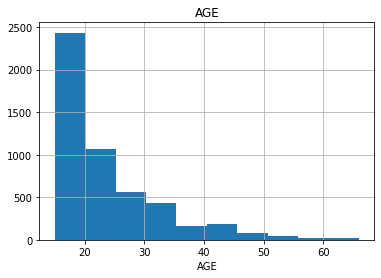

In [6]:
# num_summary function summarizes numerical variables by their statistical attributes 
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.25, 0.5, 0.75, 1]
    print(dataframe[numerical_col].describe(quantiles).T)
    
    # To get histogram plots of the variables
    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
        
for col in num_cols:
    num_summary(df, col, plot=True)

In [7]:
# An aggregated dataframe is created that shows mean price values grouped by ("COUNTRY","SOURCE","SEX","AGE") variables.
agg_df = df.groupby(["COUNTRY","SOURCE","SEX","AGE"]).agg({"PRICE": "mean"}).sort_values(by= "PRICE", ascending=False)
agg_df.head()

,,,,PRICE
COUNTRY,SOURCE,SEX,AGE,
bra,android,male,46,59.0
usa,android,male,36,59.0
fra,android,female,24,59.0
usa,ios,male,32,54.0
deu,android,female,36,49.0


In [8]:
# Reseting the index values since the variables except "PRICE" are all index names 
agg_df.reset_index(inplace=True)
agg_df.head()

,COUNTRY,SOURCE,SEX,AGE,PRICE
0,bra,android,male,46,59.0
1,usa,android,male,36,59.0
2,fra,android,female,24,59.0
3,usa,ios,male,32,54.0
4,deu,android,female,36,49.0


In [9]:
# To create customer segments first the "AGE" variable is categorized into age intervals.

# The values to be splitted from
bins = [agg_df["AGE"].min(), 18, 23, 30, 40, agg_df["AGE"].max()]

# The category labels
labels = ['0_18', '19_23', '24_30', '31_40', '41_' + str(agg_df["AGE"].max())]

agg_df["AGE_CAT"] = pd.cut(agg_df["AGE"], bins=bins, labels=labels, include_lowest=True)

# To check the labeling consistency following code can be implemented
agg_df.groupby("AGE_CAT").agg({"AGE":['min','max']})

AGE    
        min max
AGE_CAT        
0_18     15  18
19_23    19  23
24_30    24  30
31_40    31  40
41_66    41  66

In [10]:
# To define the new level based customers(persona) variable 'CUSTOMER_LEVEL_BASED'
agg_df['CUSTOMER_LEVEL_BASED'] = [(val[0] + "_" + val[1] + "_" + val[2] + "_" + val[5]).upper() for val in agg_df.values]

# The new variable values are not singularized, so it should be singularized
agg_df = agg_df.groupby("CUSTOMER_LEVEL_BASED").agg({"PRICE":'mean'})

# The index are lost so it is resetted.
agg_df.reset_index(inplace=True)

agg_df.head()

,CUSTOMER_LEVEL_BASED,PRICE
0,BRA_ANDROID_FEMALE_0_18,35.645303
1,BRA_ANDROID_FEMALE_19_23,34.077340
2,BRA_ANDROID_FEMALE_24_30,33.863946
3,BRA_ANDROID_FEMALE_31_40,34.898326
4,BRA_ANDROID_FEMALE_41_66,36.737179


In [11]:
# New customer variable is grouped into 4 segments and assigned to a new variable called "SEGMENT"
agg_df["SEGMENT"] = pd.qcut(agg_df["PRICE"], 4, labels= ["D","C","B","A"])

agg_df.head()

,CUSTOMER_LEVEL_BASED,PRICE,SEGMENT
0,BRA_ANDROID_FEMALE_0_18,35.645303,B
1,BRA_ANDROID_FEMALE_19_23,34.077340,C
2,BRA_ANDROID_FEMALE_24_30,33.863946,C
3,BRA_ANDROID_FEMALE_31_40,34.898326,B
4,BRA_ANDROID_FEMALE_41_66,36.737179,A


In [12]:
# The segments are presented by their mean, max, sum values 
agg_df.groupby("SEGMENT").agg({"PRICE":["mean","max","sum"]})

PRICE                        
              mean        max          sum
SEGMENT                                   
D        29.206780  32.333333   817.789833
C        33.509674  34.077340   904.761209
B        34.999645  36.000000   944.990411
A        38.691234  45.428571  1044.663328

In [13]:

# profit_predictor function is written to automate the process of foreseeing the profit on a new customer by using their country, device, sex and age data


def profit_predictor(country, device, sex, age):
    if age <= 18:
        age_interval = "0_18"
    elif age > 18 and age <= 23:
        age_interval = "19_23"
    elif age > 23 and age <= 30:
        age_interval = "24_30"
    elif age > 30 and age <= 40:
        age_interval = "31_40"
    elif age > 40 and age <= 66:
        age_interval = "41_66"

    print (agg_df[agg_df["CUSTOMER_LEVEL_BASED"] == (country + "_" + device + "_" + sex + "_" + age_interval).upper()])

# What is the segment of a 33 year old Turkish woman who uses Android and how much profit the company gains from her on average?
profit_predictor("tur","android","female",33)

# What is the segment of a 35 year old French woman who uses iOS and how much profit the company gains from her on average?
profit_predictor("fra","ios","female",35)

        CUSTOMER_LEVEL_BASED      PRICE SEGMENT
72  TUR_ANDROID_FEMALE_31_40  41.833333       A
    CUSTOMER_LEVEL_BASED      PRICE SEGMENT
63  FRA_IOS_FEMALE_31_40  32.818182       C
